<a href="https://colab.research.google.com/github/ashweta81/HR-Analytics-Project/blob/master/Introduction_to_Time_Series_Part_2_ARIMA_and_SARIMA_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use the data on the Industrial Production - Utilities to understand the time series forecasting better. 
<br>
The data used can be sourced from this link : https://fred.stlouisfed.org/series/IPG2211A2N
<br>
The data set gives the monthly industrial production of all gas and electrical utilities in the United States from 1940 to 2020.



In [10]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy import mean
from sklearn.metrics import mean_squared_error
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from matplotlib import pyplot
import warnings
import itertools

In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [12]:
from google.colab import drive

In [13]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [14]:
df = pd.read_csv('/drive/My Drive/Colab Notebooks/Data.csv')

In [15]:
print(df.head())

         DATE  IPG2211A2N
0  1939-01-01      3.3298
1  1939-02-01      3.3552
2  1939-03-01      3.4315
3  1939-04-01      3.4569
4  1939-05-01      3.4569


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        989 non-null    object 
 1   IPG2211A2N  989 non-null    float64
dtypes: float64(1), object(1)
memory usage: 15.6+ KB


In [17]:
df.shape

(989, 2)

Here the Date column is an object. We need to convert it into date time. We will rename the name of the second column

In [18]:
import datetime

In [19]:
df['Date'] = pd.to_datetime(df['DATE'], dayfirst=True)
df[['Date','DATE']].head(2)

,Date,DATE
0,1939-01-01,1939-01-01
1,1939-02-01,1939-02-01


In [20]:
df.drop(['DATE'], axis=1, inplace=True)

In [21]:
df.set_index('Date', inplace=True)

In [22]:
df = df.rename(columns={'IPG2211A2N' :'Energy_Production'})

In [23]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 989 entries, 1939-01-01 to 2021-05-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Energy_Production  989 non-null    float64
dtypes: float64(1)
memory usage: 15.5 KB


(989, 1)

There are 989 observations in the dataframe and no missing data. Lets plot the time series. 

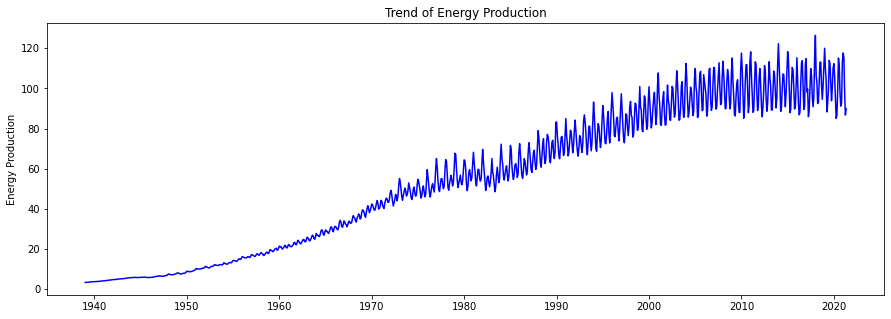

In [24]:
plt.figure(figsize=(15,5))
plt.ylabel('Energy Production')
plt.title('Trend of Energy Production')
plt.plot(df['Energy_Production'],'b-');

If we plot the energy production, we can observe that there is both trend and seasonality. We can decompose the time series data into its individial components using the function 'decompose' in Python.
<br>
<br>
On using this function, we get four different plots. These include the overall visual plot of the series, the trend component, the seasonal component and the residual.If we observe these individual plots, we can infer that both the trend and seasonal components are present in the time series and it is additive. What does this mean? 
<br>
<br>
<b> Additive time series <b> is one in which the magnitude of trend and seasonality does not increase with time. They remain fairly constant. 
<b> Multiplicative time series <b> is one in which the magnitude of trend and seasonality increases as time period increases.

Our data here is aggregated by month. The period we want to analyze is by year so that's why we set the period frequency to 12.

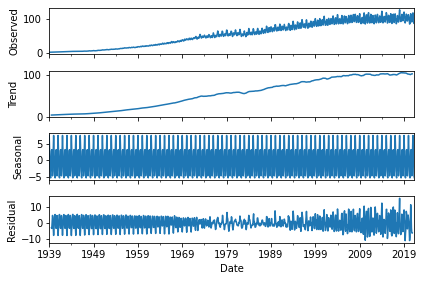

In [25]:
y_decompose = seasonal_decompose(df['Energy_Production'], model = 'additive', freq = 12)
y_decompose_plot = y_decompose.plot()

We can observe the seasonal and tend components in more detail in the below graphs

# Seasonal Component of Time Series

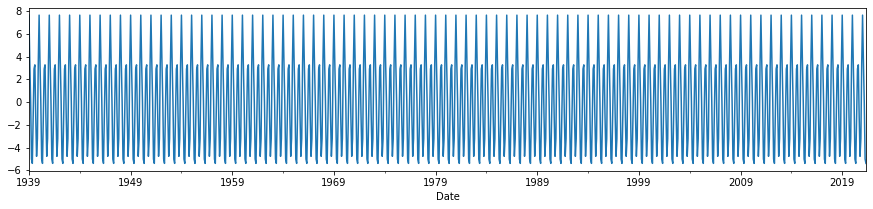

In [26]:
plt.figure(figsize=(15,3))
y_decompose.seasonal.plot();

# Trend Component of Time Series

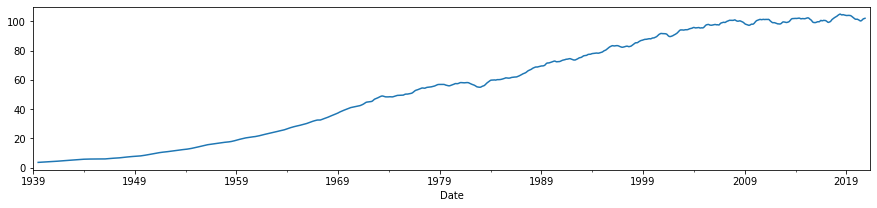

In [27]:
plt.figure(figsize=(15,3))
y_decompose.trend.plot();

From the plots above, we can conclude that there is both seasonality and trend present in the data. 

We will first use simple methods of forecasting, check the error metrics (RMSE and MAPE) and then use more complex forecasting measures like ARIMA

# Method 3 AutoRegressive Moving Average Models (ARIMA)

ARIMA is a statistical model used for forecasting time series data. It describes the autocorrelation present in the data. As the name suggest, it consists of three terms.

<b> AR : Auto Regression : The time series is regressed with its previous values <b>

<b> I : Integration : The time series uses differencing to make it stationary <b>

<b> MA : Moving Average : The time series is regressed with residuals of the past observations <b>

ARIMA by itself does not support seasonal data. For time series that has a significant seasonal pattern, seasonal ARIMA models are used.

<b> SARIMA is short for seasonal ARIMA. Its an extension of ARIMA method that supports seasonality in data. 
In addition to the three parameters in ARIMA i.e. p,d,q, SARIMA has three more seasonal parameters (P,D,Q). The additional three parameters account for Autoregressive component, Differencing component and Moving Average Component at the Seasonal Level. 
<br>
<br>
It can be expressed as follows: ARIMA (p,d,q) (P,D,Q)m 
<br>
Here m is number of observations per season. The seasonal components of the model are expressed in upper case and non seasonal components of the model are expressed in lower case. <b>

Before we get into the details of SARIMA, lets understand the term 'Autocorrelation' and 'Partial Autocorrelation'. 
This method extensively uses autocorrelation and partial autocorrelation. Hence it is important to understand these concepts. 

<b>Auto-Correlation Function (ACF) : Auto-correlation of lag k is the correlation between Yt and Yt-k, measured at different k values. For lag 1, Auto correlation is measured between Yt and Yt-1, similarly for lag 2, Auto correlation is measured between Yt and Yt-2 values. A plot of auto-correlation for different values of k is called an auto-correlation plot or correlogram.<b>

<b> Partial Auto-Correlation (PACF) : Partial Auto Correlation of lag k is the correlation between Yt and Yt-k when the effectof all other intermediate values (Yt-1, Yt-2,....Yt-k+1) is removed from both Yt and Yt-k. A plot of partial auto correlation for different values of k is called partial auto correlation plot . <b>

Before we use ARIMA, we need to ensure that the time series is stationary. 

<b> What do you mean by stationarity of time series? <b>

A time series is said to be stationary if it has the following three properties: 
1. It has a constant mean i.e. mean remains constant over time
2. It has a constant variance i.e. variance remains constant over time
3. It has a constant covariance. Value of the covariance between the two time periods depend on the lag between the two time periods and not on the actual time at which the covariance is computed.

A stationary time series will have the same mean, variance and covariance no matter at what point we measure them, these are then actually time invariant. 

<b> Why do we need stationary time series? Because if the time series is not stationary, we can study its behavior only for that time period. Each period of the time series will have its own distinct behaviour and it is not possible to predict or generalize for future time periods. <b>

A stationary time series will tend to return to its mean value and the fluctuations around this mean will have a broadly constant magnitude.
Thus, a stationary time series will not drift too much from its mean value because of the finite variance.A time series with white noise is a stationary series cause it has no predictable patterns in the long term and has a constant variance.It is memoryless. 

Here is how a distribution of White Noise will look like: 

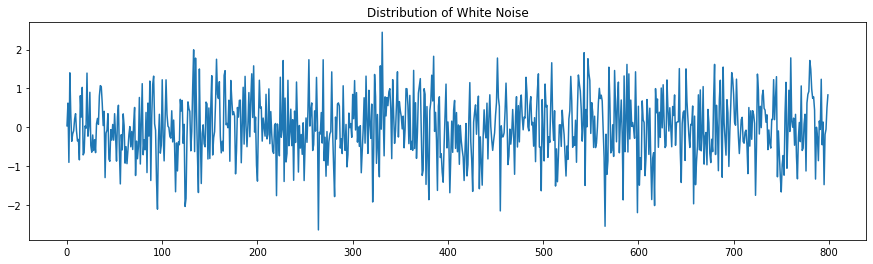

In [28]:
# Plot for White Noise with Mean 0 and standard deviation as 0.8
wnoise= np.random.normal(loc=0, scale=0.8, size=800)
plt.figure(figsize=(15, 4)),
plt.plot(wnoise);
plt.title('Distribution of White Noise');

As you can see from the plot above, the distribution is constant across the mean and is completely random. Its difficult to predict the next movement of the time series. If I plot the autocorrelation of this series, one will observe complete zero autocorrelations. 

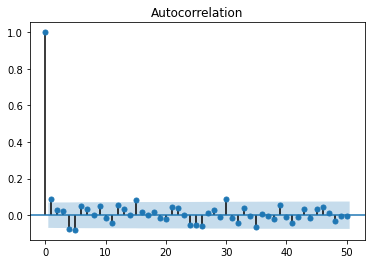

In [29]:
acr = plot_acf(wnoise, lags = 50)

<b> How do we check for stationarity? <b>


To check for stationarity, we use a statistical test known as Dickey Fuller Test. This test belongs to the category called the Unit Root test. 


The test checks whether the time series has a unit root and hence is non stationary. 
<br>
<br>
Null Hypothesis Ho : There is a unit root i.e. the time series is non stationary
<br>
Alternate Hypothesis Ha : There is no unit root i.e. the time series is stationary

<b> What do you mean by Unit Root? <b>

A non stationary time series will have a unit root. Thus, when we check for stationarity, we check for unit root. If 
the time series has an unit root, we conclude that the series is not stationary.
<br>
There are two kinds of non stationary stochastic time series that are observed :
    1. Random Walk Model Without Drift (RWM)
    2. Random Walk Model with Drift 

In Random Walk Without Drift, the mean of the series is constant but the variance increases with time. Thus the series is non stationary. Usually, the stock prices are considered to be Random Walk. <br>
In a time series with Random Walk, the value of the time series Y at time t is equal to its value at time t-1 plus a random shock i.e. 
Yt = Yt-1 + ut
<br>
The first difference of the Random Walk Without Drift is a stationary time series. Why? Cause Yt - Yt-1 = ut is a white noise or stationary series with mean 0 and constant variance
<br>
<br>
In Random Walk With Drift, both the mean of the series and the variance increase with time. Thus, the series is not stationary. In a Random Walk With Drift, the value of time series at time t is equal to its value at time t-1 plus a drift parameter delta plus a random shock i.e. Yt = Yt-1 + delta + ut
<br>
<br>
A Random Walk Model is known as a unit root process. It is written as :
Yt = (Delta)* Yt-1 + ut, where the value of delta is between -1 and 1. 
<br>
<br>
If the value of delta is 1 or greater than 1, the series is non stationary. If the value of delta is less than 1, we conclude that the series is stationary

<b> We will perform the Dickey Fuller Test on the given time series to confirm stationarity. <b>
    We will also perform KPSS test as an additional test to confirm stationarity

Null and Alternate Hypothesis for Dickey Fuller Tests is : 
<b> Null Hypothesis Ho : Series has a unit root i.e. non stationary time series
<br>
Alternate Hypothesis Ha : Series does not have a unit root i.e. stationary time series
<b>

Null and Alternate Hypothesis for KPSS Tests is :
<b> Null Hypothesis Ho <b> : Series does not have a unit root i.e. stationary time series
<b> Alternate Hypothesis Ha <b> : Series has a unit root i.e. non stationary time series

For ARIMA modeling, we will take the data from 1965 onwards

In [30]:
df1 = df.copy()

In [31]:
df2 = df1['Energy_Production'][312:]
df2 = pd.DataFrame(df2)
df2.head()

,Energy_Production
Date,
1965-01-01,29.4598
1965-02-01,28.7989
1965-03-01,28.8497
1965-04-01,28.1889
1965-05-01,27.7059


Lets now run the Dickey Fuller test to check for stationarity

In [32]:
X = df2['Energy_Production'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.231551
p-value: 0.194994
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


<b> As the p value is greater than 5%, we will accept the Null Hypothesis. Thus, the series is non stationary.<b> 

Lets also run the KPSS test to confirm non stationarity. here the null hypothesis is that the series is stationary and the alternate hypothesis is that series is not stationary. 

In [33]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [34]:
kpss_test(df2['Energy_Production'].values)

Results of KPSS Test:
Test Statistic            3.273962
p-value                   0.010000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


As p value is less than 5%, we reject the Null Hypothesis that the series is stationary. We therefore conclude that series is not stationary. 

If the series is non stationary, we need to transform the series to make it stationary so that it can be used for prediction.
One of the ways to transform the data is to do differencing if it is a stochastic non stationary series and detrending if it is a deterministic non stationary time series. 

We will difference the time series to make the it stationary. We will use the differencing of order 12 as it is monthly data - subtraction of series from itself with lag 12

In [35]:
df2['Energy_Production_diff'] = df2['Energy_Production'] - df2['Energy_Production'].shift(12)
df2[['Energy_Production','Energy_Production_diff']].head(13)

,Energy_Production,Energy_Production_diff
Date,,
1965-01-01,29.4598,NaN
1965-02-01,28.7989,NaN
1965-03-01,28.8497,NaN
1965-04-01,28.1889,NaN
1965-05-01,27.7059,NaN
1965-06-01,28.6972,NaN
1965-07-01,29.9936,NaN
1965-08-01,31.0103,NaN
1965-09-01,30.8578,NaN


We need to remove the NaN values for further processing. We will further plot the data to see if the trend and seasonality has been accounted for.

In [36]:
df2['Energy_Production_diff1'] = df2['Energy_Production_diff'].dropna()

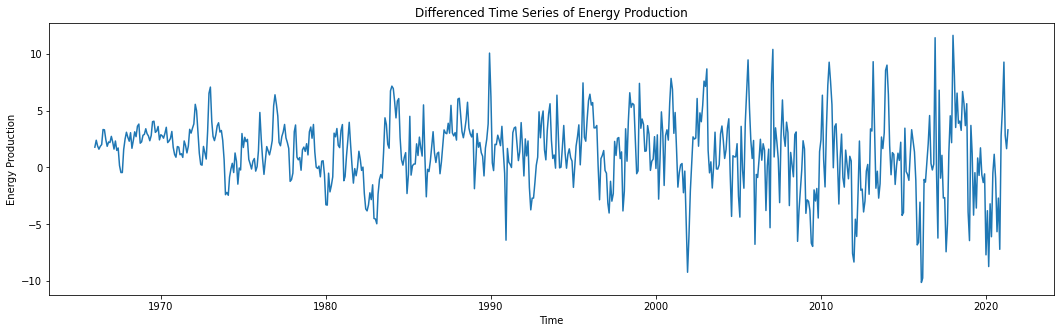

In [37]:
plt.figure(figsize=(18,5));
plt.xlabel('Time');
plt.ylabel('Energy Production');
plt.title('Differenced Time Series of Energy Production');
plt.plot(df2['Energy_Production_diff1']);

We can see that the mean is nearly zero but it still has non constant variance. We will run the Dickey Fuller Test on the differenced data to check if the series is stationary. 

In [38]:
X = df2['Energy_Production_diff1'].dropna().values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.448126
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


Lets also check the KPSS test statistics. 

In [39]:
kpss_test(X)

Results of KPSS Test:
Test Statistic            0.575462
p-value                   0.024867
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<b> While the Dickey Fuller test confirms that the series is stationary, the KPSS test confirms that the series is not stationary. We will also check the ACF and PACF plots to look at the significant lags.<b>

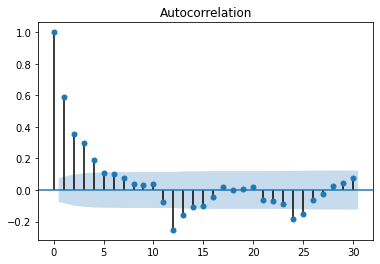

In [40]:
acf_plot = plot_acf(df2['Energy_Production_diff1'].dropna(), lags= 30) 

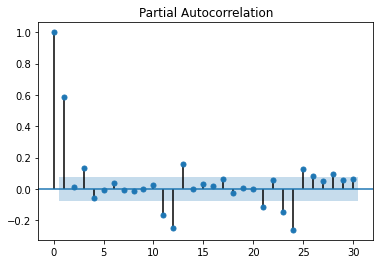

In [41]:
pacf_plot = plot_pacf(df2['Energy_Production_diff1'].dropna(), lags= 30) 

We can see that series still has many significant positive autocorrelation  lags. To remove them we will take first differences — subtraction of series from itself with lag 1

In [42]:
df2['Energy_Production_diff121'] = df2['Energy_Production_diff1'] - df2['Energy_Production_diff1'].shift(1)

In [43]:
df2.head(15)

,Energy_Production,Energy_Production_diff,Energy_Production_diff1,Energy_Production_diff121
Date,,,,
1965-01-01,29.4598,NaN,NaN,NaN
1965-02-01,28.7989,NaN,NaN,NaN
1965-03-01,28.8497,NaN,NaN,NaN
1965-04-01,28.1889,NaN,NaN,NaN
1965-05-01,27.7059,NaN,NaN,NaN
1965-06-01,28.6972,NaN,NaN,NaN
1965-07-01,29.9936,NaN,NaN,NaN
1965-08-01,31.0103,NaN,NaN,NaN
1965-09-01,30.8578,NaN,NaN,NaN


In [44]:
df2['Energy_Production_diff121'] = df2['Energy_Production_diff121'].dropna()

In [45]:
X = df2['Energy_Production_diff121'].dropna().values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.939993
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [46]:
kpss_test(X)

Results of KPSS Test:
Test Statistic            0.017791
p-value                   0.100000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Both tests are confirming that the series is stationary. We can therefore conclude that the series is stationary. Lets also plot the acf and pacf plots. 

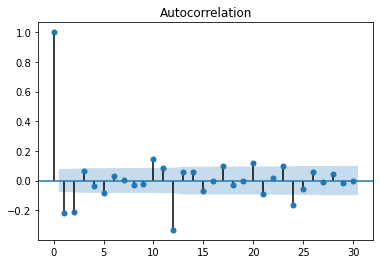

In [47]:
acf_plot = plot_acf(df2['Energy_Production_diff121'].dropna(), lags= 30) 

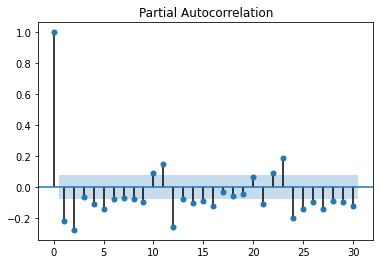

In [48]:
pacf_plot = plot_pacf(df2['Energy_Production_diff121'].dropna(), lags= 30) 

The series looks overdifferenced due to high number of negative autocorrelations. Also there are too many significant negative lags both in ACF and PACF plots

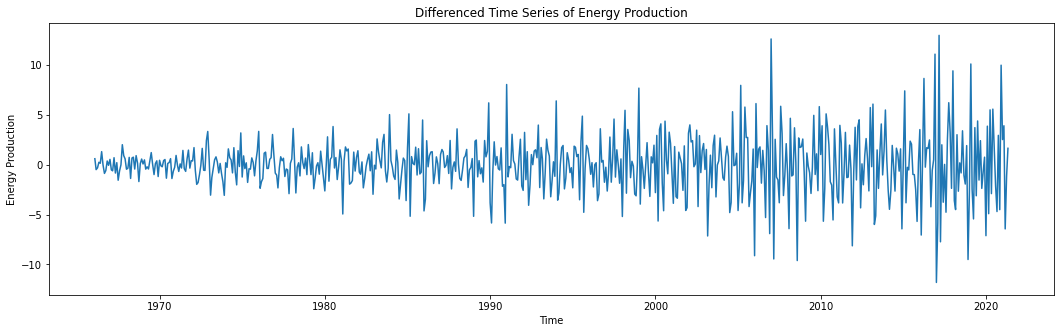

In [49]:
plt.figure(figsize=(18,5));
plt.xlabel('Time');
plt.ylabel('Energy Production');
plt.title('Differenced Time Series of Energy Production');
plt.plot(df2['Energy_Production_diff121']);

The best practice is not difference the series more than two times. We will retain the series as it is. We also tried log and square root transformation separately but were unable to make the series stationary. We will now go ahead and use two approaches to build the model. The first approach is to determine the AR and MA terms from the ACF and PACF plots and then use these as a rough guide to create an AUTO ARIMA model. 

From the ACF and PACF plots , we can see that there is a negative seasonal autocorrelation at s=12, 24. As per the guideline, if the autocorrelation at the seasonal period is negative, we should add a SMA term. The seasonal differencing is 1 and non seasonal differencing is also 1. For the AR and MA terms, we can see that both ACF and PACF plots have a negative autocorrelation at lag 1 and 2. Thus, in this case an MA term will explain the autocorrelation better than the AR terms. Thus, the final model order is SARIMA (0,1,2)(0,1,1)12. 

We will keep the order of the parameters derived from the ACF and PACF plots as guideline when building SARIMA models using autoarima function 

In [52]:
pip install pmdarima

     |████████████████████████████████| 1.5 MB 15.5 MB/s 
     |████████████████████████████████| 9.5 MB 71.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [53]:

import pmdarima as pm

In [54]:
from pmdarima import auto_arima

In [55]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [56]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 677 entries, 1965-01-01 to 2021-05-01
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Energy_Production          677 non-null    float64
 1   Energy_Production_diff     665 non-null    float64
 2   Energy_Production_diff1    665 non-null    float64
 3   Energy_Production_diff121  664 non-null    float64
dtypes: float64(4)
memory usage: 26.4 KB


In [57]:
df3 = df2['Energy_Production']

In [58]:
model = auto_arima(df3, start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,start_P=0,start_Q=0,
                          max_P = 2, max_Q = 2,
                          seasonal=True,
                          d=1,D=1,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3281.487, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3171.654, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3018.258, Time=0.58 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3218.537, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3015.997, Time=0.92 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3141.548, Time=0.28 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2994.828, Time=1.94 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3058.224, Time=0.81 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2977.369, Time=5.76 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3010.587, Time=3.48 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=3047.276, Time=4.01 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=2912.252, Time=7.25 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=2931.644, Time=4.72 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=2918.937, Time=3.15 sec
 ARIMA(1,1,1)(1,1,1

In [59]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  677
Model:             SARIMAX(1, 1, 1)x(2, 1, 2, 12)   Log Likelihood               -1449.126
Date:                            Wed, 28 Jul 2021   AIC                           2912.252
Time:                                    17:14:03   BIC                           2943.740
Sample:                                         0   HQIC                          2924.454
                                            - 677                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5133      0.034     15.039      0.000       0.446       0.580
ma.L1         -0.9304      0.018   

In [60]:
# Let us divide the data into train and test set. 

In [61]:
df3.shape

(677,)

In [62]:
train = df3[:612]
test = df3[612:]

In [63]:
train.head()
test.head()

Date
1965-01-01    29.4598
1965-02-01    28.7989
1965-03-01    28.8497
1965-04-01    28.1889
1965-05-01    27.7059
Name: Energy_Production, dtype: float64

Date
2016-01-01    115.2108
2016-02-01    104.4120
2016-03-01     92.8431
2016-04-01     86.8528
2016-05-01     88.1400
Name: Energy_Production, dtype: float64

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [65]:
final_model = SARIMAX(train,order=(1,1,1),seasonal_order=(2,1,2,12))

In [66]:
result = final_model.fit()

In [67]:
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                  Energy_Production   No. Observations:                  612
Model:             SARIMAX(1, 1, 1)x(2, 1, 2, 12)   Log Likelihood               -1247.862
Date:                            Wed, 28 Jul 2021   AIC                           2509.724
Time:                                    17:14:32   BIC                           2540.491
Sample:                                01-01-1965   HQIC                          2521.702
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5832      0.038     15.368      0.000       0.509       0.658
ma.L1         -0.9411      0.017   

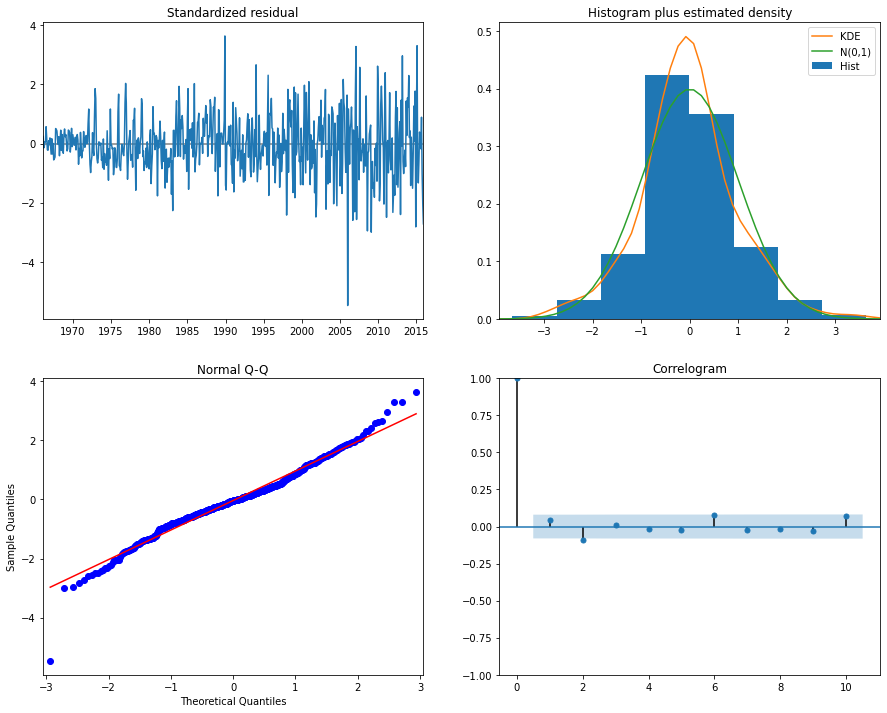

In [68]:
result.plot_diagnostics(figsize=(15, 12));

In [69]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,1)(2,1,2,12) Predictions')

In [70]:
#Passing dynamic=False means that forecasts at each point are generated using the full history up to that point (all lagged values).

#Passing typ='levels' predicts the levels of the original endogenous variables. If we'd used the default typ='linear' we would have seen linear predictions in terms of the differenced endogenous variables.

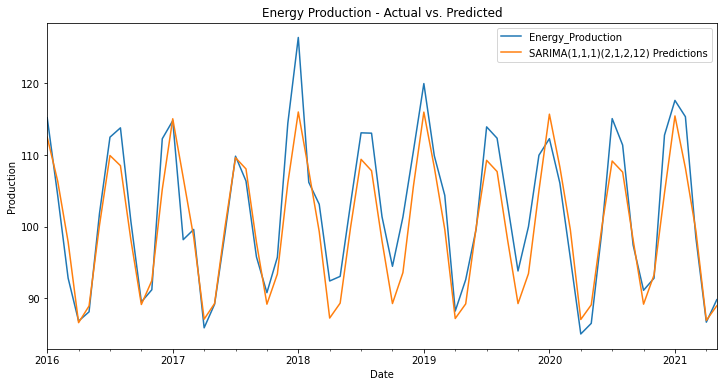

In [71]:
# Plot predictions against known values
title = 'Energy Production - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [73]:
# Calculating accuracy  of the model. 

In [74]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(error)

4.0475634972176415


In [75]:
# Function for MAPE
def get_mape(actual, predicted):
    return np.round(np.mean(np.abs((actual-predicted) / actual))*100,2)

In [76]:
get_mape(test, predictions)

3.09